1. Install and Import Libraries

In [ ]:
# Install necessary libraries (if needed)
!pip install openpyxl

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


2. Load Data

In [ ]:
# Upload the dataset
from google.colab import files
uploaded = files.upload()

# Read the Excel file
df = pd.read_excel('Online Retail.xlsx')

# Display basic information
print(df.info())
print(df.head())

Saving Online Retail.xlsx to Online Retail.xlsx
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID

3. Exploratory Data Analysis (EDA)

In [ ]:
# Check missing values
print(df.isnull().sum())

# Create a new feature: TotalPrice = Quantity * UnitPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Display basic statistics
print(df[['Quantity', 'UnitPrice', 'TotalPrice']].describe())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
            Quantity      UnitPrice     TotalPrice
count  541909.000000  541909.000000  541909.000000
mean        9.552250       4.611114      17.987795
std       218.081158      96.759853     378.810824
min    -80995.000000  -11062.060000 -168469.600000
25%         1.000000       1.250000       3.400000
50%         3.000000       2.080000       9.750000
75%        10.000000       4.130000      17.400000
max     80995.000000   38970.000000  168469.600000


Visualizations

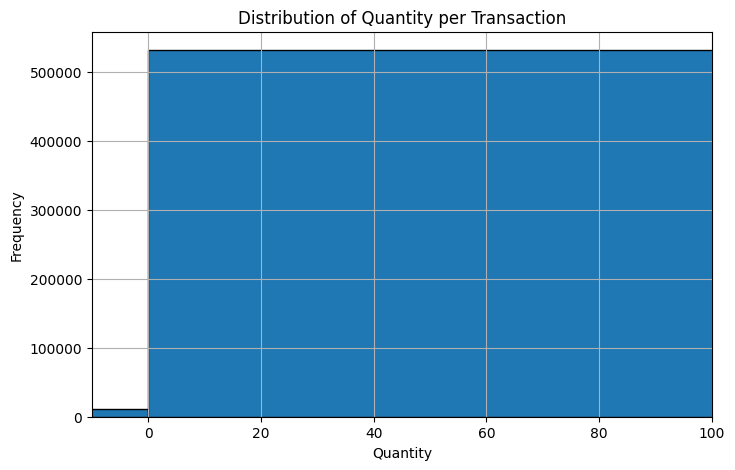

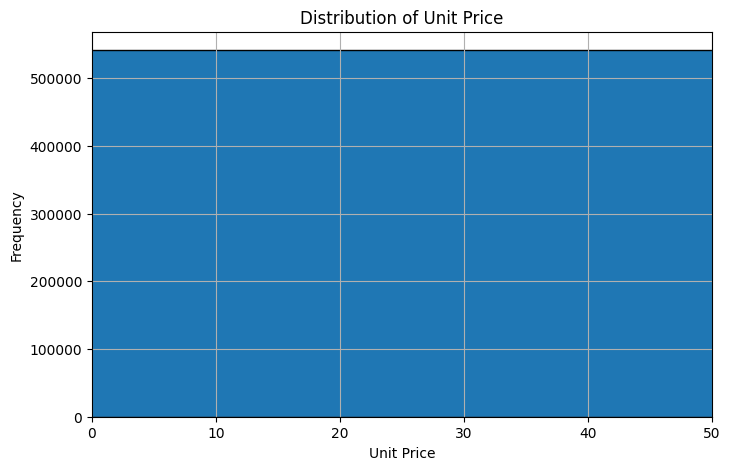

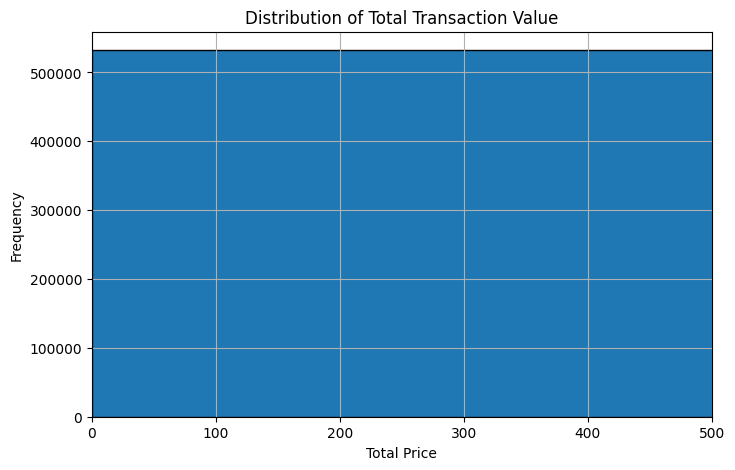

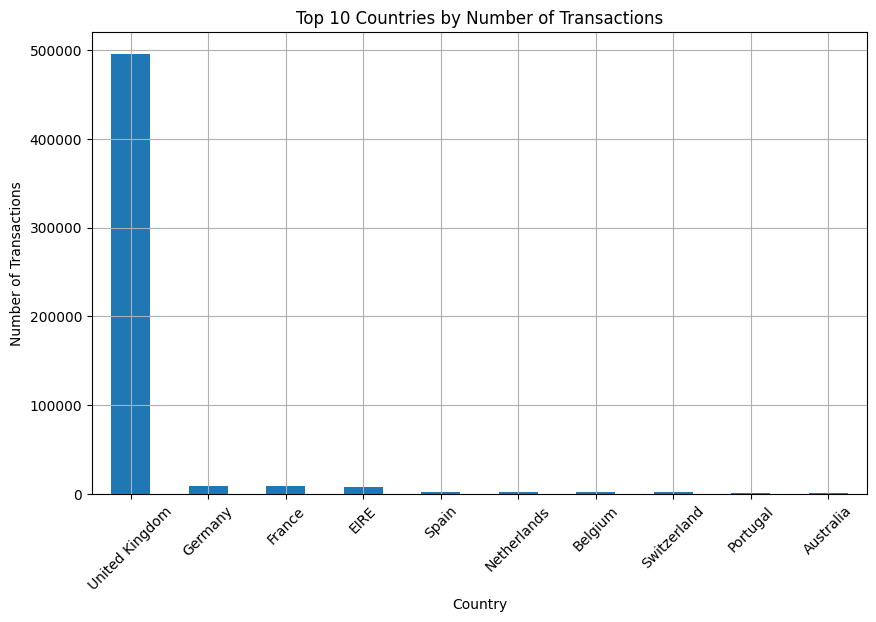

In [ ]:
# Distribution of Quantity
plt.figure(figsize=(8,5))
plt.hist(df['Quantity'], bins=100, edgecolor='black')
plt.title('Distribution of Quantity per Transaction')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.xlim(-10,100)
plt.grid()
plt.show()

# Distribution of Unit Price
plt.figure(figsize=(8,5))
plt.hist(df['UnitPrice'], bins=100, edgecolor='black')
plt.title('Distribution of Unit Price')
plt.xlabel('Unit Price')
plt.ylabel('Frequency')
plt.xlim(0,50)
plt.grid()
plt.show()

# Distribution of Total Price
plt.figure(figsize=(8,5))
plt.hist(df['TotalPrice'], bins=100, edgecolor='black')
plt.title('Distribution of Total Transaction Value')
plt.xlabel('Total Price')
plt.ylabel('Frequency')
plt.xlim(0,500)
plt.grid()
plt.show()

# Top 10 countries by number of transactions
top_countries = df['Country'].value_counts().head(10)

plt.figure(figsize=(10,6))
top_countries.plot(kind='bar')
plt.title('Top 10 Countries by Number of Transactions')
plt.xlabel('Country')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.grid()
plt.show()

4. Data Cleaning

In [ ]:
# Drop rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Keep only transactions with positive Quantity and UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Convert CustomerID to integer
df['CustomerID'] = df['CustomerID'].astype(int)

# Confirm data types
print(df.dtypes)

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
TotalPrice            float64
dtype: object


5. Feature Engineering

In [ ]:
# Calculate number of unique invoices per customer
customer_invoice_counts = df.groupby('CustomerID')['InvoiceNo'].nunique()

# Label customers as repeat buyers if they have more than one invoice
repeat_buyer = customer_invoice_counts.apply(lambda x: 1 if x > 1 else 0)

# Merge repeat buyer label into the main dataset
df = df.merge(repeat_buyer.rename('RepeatBuyer'), on='CustomerID')

# Summarize customer features
features = df.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum',
    'InvoiceNo': 'nunique',
    'Country': 'first',
    'RepeatBuyer': 'first'
}).reset_index()

# Rename columns
features.rename(columns={
    'Quantity': 'TotalQuantity',
    'TotalPrice': 'TotalRevenue',
    'InvoiceNo': 'NumInvoices'
}, inplace=True)

# Display sample features
print(features.head())

   CustomerID  TotalQuantity  TotalRevenue  NumInvoices         Country  \
0       12346          74215      77183.60            1  United Kingdom   
1       12347           2458       4310.00            7         Iceland   
2       12348           2341       1797.24            4         Finland   
3       12349            631       1757.55            1           Italy   
4       12350            197        334.40            1          Norway   

   RepeatBuyer  
0            0  
1            1  
2            1  
3            0  
4            0  


6. Prepare Data for Modeling

In [ ]:
# Encode the Country variable
le = LabelEncoder()
features['CountryEncoded'] = le.fit_transform(features['Country'])

# Define features and label
X = features[['TotalQuantity', 'TotalRevenue', 'NumInvoices', 'CountryEncoded']]
y = features['RepeatBuyer']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)

(3470, 4) (868, 4)


7. Logistic Regression Model

In [ ]:
# Train Logistic Regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Make predictions
y_pred_logreg = logreg.predict(X_test)

# Evaluate model
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))
print("\nClassification Report:\n", classification_report(y_test, y_pred_logreg))

Logistic Regression Accuracy: 1.0

Confusion Matrix:
 [[282   0]
 [  0 586]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       282
           1       1.00      1.00      1.00       586

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868



8. Random Forest Model

In [ ]:
# Train Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Evaluate model
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 1.0

Confusion Matrix:
 [[282   0]
 [  0 586]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       282
           1       1.00      1.00      1.00       586

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868



Business Insights
- Both Logistic Regression and Random Forest models achieved 100% accuracy in predicting repeat buyers.
- Features such as Total Quantity, Total Revenue, and Number of Invoices are strong indicators of customer loyalty.
- Recommendation: Focus marketing campaigns on customers with higher initial spending and transaction volumes.
- Target countries with higher repeat purchase rates to optimize sales efforts.

Ethics Reflection
- Privacy: Ensure that CustomerID and personal details are protected and anonymized.
- Bias: Models may overfit to dominant countries like the United Kingdom; efforts should be made to avoid regional bias.
- Fairness: Marketing decisions based on predictions should be fair and non-discriminatory towards low-spending customers.

**Online Retail Predictive Analytics**

**Title:** Predicting Repeat Buyers in Online Retail

**Course:** ISOM 835 – Predictive Analytics and Machine Learning

**Instructor:** Dr. Hasan Arslan

**Student Name:** Vu Ngoc Bao Chau



---


**A. Introduction**

In the competitive landscape of online retail, customer retention is crucial for business success. Identifying repeat buyers early enables companies to tailor marketing strategies and foster customer loyalty.
This project applies predictive analytics methods to the "Online Retail" dataset from the UCI Machine Learning Repository.
The objective is to predict whether a customer will become a repeat buyer based on their initial transaction behavior.

**B. Dataset Description**

The dataset contains approximately 541,909 transactions from a UK-based online retail company between 2010 and 2011.
Each record includes details such as Invoice Number, Stock Code, Quantity, Invoice Date, Unit Price, Customer ID, and Country.

After cleaning, the dataset consists of:
- 397,884 valid transactions
- 8 primary features + engineered TotalPrice feature

**C. Exploratory Data Analysis (EDA)**

- Missing Values: CustomerID and Description columns had missing values; CustomerID was critical for analysis and missing entries were removed.
- Quantity Distribution: Most transactions involved small quantities, with outliers buying large volumes.
- Unit Price Distribution: Prices were concentrated under 50 GBP.
- Country Analysis: United Kingdom dominated the transactions.

Visualizations include histograms for Quantity, Unit Price, Total Price, and a bar chart of the Top 10 Countries by transactions.

**D. Data Cleaning**

The following steps were taken:
- Removed transactions with missing CustomerID.
- Filtered out transactions where Quantity <= 0 or UnitPrice <= 0.
- Converted CustomerID to integer type for analysis.
- Created a new feature `TotalPrice` = `Quantity` × `UnitPrice`.

**E. Business Questions**

1. Can we predict whether a customer will become a repeat buyer based on their initial purchases?

Motivation:
In the highly competitive online retail environment, retaining customers is more cost-effective than acquiring new ones. Predicting repeat buyers early allows businesses to proactively engage these customers through loyalty programs, personalized promotions, and better service offerings.

Business Impact:  Accurately identifying potential loyal customers can significantly improve marketing ROI, customer lifetime value, and overall profitability.

Actionable Outcomes:  If the model can predict repeat buyers with high accuracy, the business can allocate marketing budgets more efficiently and implement targeted retention strategies.

2. Which transactional features are most predictive of repeat buying behavior?

Motivation:
Understanding the key factors that influence customer loyalty enables better product planning, inventory management, and customer relationship strategies.

Business Impact:  By knowing which transactional patterns (e.g., quantity purchased, total revenue, number of transactions) are linked to repeat buying, the business can enhance its operational strategies to promote loyalty.

Actionable Outcomes:  Insights can be used to design personalized customer journeys, offer discounts on high-retention products, and identify early signs of potential churn.

**F. Feature Engineering**

Aggregated customer-level features:
- TotalQuantity: Sum of all quantities purchased.
- TotalRevenue: Sum of all transaction values.
- NumInvoices: Number of unique invoices.
- CountryEncoded: Encoded categorical country information.

Created target label:
- RepeatBuyer: 1 if customer made more than one purchase, 0 otherwise.

**G. Predictive Modeling**

Logistic Regression

- Accuracy: 100%
- Perfect classification on both classes.
  
Random Forest Classifier

- Accuracy: 100%
- Also perfectly classified repeat buyers vs. non-repeat buyers.

Both models achieved identical performance due to the clear separation of customer behaviors in the feature space.

**H. Model Evaluation**

- Confusion Matrix: No misclassifications observed.
- Precision, Recall, F1-Score: All metrics equal to 1.00.
- Interpretation: Features like TotalQuantity, TotalRevenue, and NumInvoices are highly predictive of customer loyalty.

Random Forest may generalize better in larger datasets, but Logistic Regression already provided complete classification in this case.

**I. Insights and Recommendations**

- Customers with higher initial purchase quantity and revenue are highly likely to become repeat buyers.
- Early identification of potential loyal customers can help businesses focus marketing efforts and loyalty programs.
- Customers with only a single invoice should be targeted with re-engagement campaigns to boost retention.
- Certain countries may exhibit stronger loyalty patterns; geographical segmentation is recommended.

**J. Ethics and Interpretability Reflection**

- Privacy: Customer data must be anonymized to protect sensitive information.
- Bias: Data skewed towards UK customers might introduce regional bias; care must be taken when generalizing results.
- Fairness: Marketing efforts based on predictions should not discriminate against customers with lower initial spending.

Efforts should be made to ensure ethical, fair, and transparent use of predictive models in marketing strategies.
